# A Movie behind a Script


In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.types import *
import pyspark.sql.functions as psf
from pyspark.sql.utils import AnalysisException

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns

#os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.10:0.4.1 pyspark-shell'



In [2]:
spark = SparkSession.builder.getOrCreate()
#spark.conf.set('spark.sql.session.timeZone', 'UTC')
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# Overview of datasets

The OpenSubtitles dataset is a compressed cluster of folders containing XML files. Each XML file is split into a script portion with the subtitles of the movie and a metadata portion with additional information about the movie or show. The name of the second-parent folder of the XML file is the corresponding IMDb identifier of the movie or show, thus allowing us to extract additional information from the IMDb dataset.

## IMDb Dataset

We use the IMDb basics dataset, which provides us with a title's main information, and the ratings datasets, which provides us the IMDb rating and votes information for each title.

In [3]:
df_basics = spark.read.parquet("parquets/basics.parquet")
df_basics.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: double (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [4]:
df_ratings = spark.read.parquet("parquets/ratings.parquet")
df_ratings.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- averageRating: float (nullable = true)
 |-- numVotes: integer (nullable = true)



## OpenSubtitles dataset

The dataset consists of 31 GB of XML files distributed in the following file structure: 

```
├── opensubtitle
│   ├── OpenSubtitles2018
│   │   ├── Year
│   │   │   ├── Id
│   │   │   │   ├── #######.xml.gz
│   │   │   │   ├── #######.xml.gz
│   ├── en.tar.gz
│   ├── fr.tar.gz
│   ├── zh_cn.tar.gz
```
where
- `######` is a 6-digit unique identifier of the file on the OpenSubtitles dataset.
- `Year` is the year the movie or episode was made.
- `Id` is a 5 to 7 digit identifier (if it's 7-digit it's also an IMDb identifier).

The subtitles are provided in different languages. We only analyze the `OpenSubtitles2018` folder and it's the only folder we detail.

The decompressed XML files vary in size, ranging from 5KB to 9000KB sized files.

Each XML file is split into a `document` and `metadata` section.

### Document

The `document` section contains all the **subtitles** and its general structure is the following:

```
├── s
│   ├── time: Integer
│   ├── w: String
```

An example snippet of an XML file:

```xml
  <s id="1">
    <time id="T1S" value="00:00:51,819" />
    <w id="1.1">Travis</w>
    <w id="1.2">.</w>
    <time id="T1E" value="00:00:53,352" />
  </s>
```

The subtitles in each XML file are stored by **blocks** denoted by `s` with a unique `id` attribute (integers in increasing order starting at 1).  

Each block (`<s id="1">` for instance) has a:  

1. Set of timestamps (denoted by `time`) with
 - A timestamp `id` attribute that can take two different formats: `T#S` or `T#E`, where _S_ indicates _start_, _E_ indicates _end_ and _#_ is an increasing integer. 
 - A `value` attribute which has the format `HH:mm:ss,fff`.

2. Set of words (denoted by `w`) with
 - an `id` attribute that is simply an increasing number of decimal numbers of the format `X.Y` where X is the string id and Y is the word id within the corresponding string
 - a non-empty `value` attribute that contains a token: a word or a punctuation character. 

It sometimes also has an `alternative`, `initial` and `emphasis` attribute.  

 - The `initial` attribute generally corresponds to slang words or mispronounced words because of an accent such as _lyin'_ instead of _lying_.  
 - The `alternative` attribute is another way of displaying the subtitle for example _HOW_ instead of _how_.
 - The `emphasis` attribute is a boolean.

### Metadata

The `metadata` section has the following structure:

```
├── Conversion
│   ├── corrected_words: Integer
│   ├── sentences: Integer
│   ├── tokens: Integer
│   ├── encoding: String (always utf-8)
│   ├── unknown_words: Integer
│   ├── ignored_blocks: Integer
│   ├── truecased_words: Integer
├── Subtitle
│   ├── language: String
│   ├── date: String
│   ├── duration: String
│   ├── cds: String (presented as #/# where # is an int)
│   ├── blocks: Integer
│   ├── confidence: Double
├── Source
│   ├── genre: String[] (up to 3 genres)
│   ├── year: Integer
│   ├── duration: Integer (in minutes)
│   ├── original: String
│   ├── country: String
```

We note that some XML files may not have all the entries. 
We can use the metadata to obtain additional information about the movie or show's subtitles and compute certain statistics. 

## Exploration of our data sets

Going through the dataset we notice a few things:

1. The dataset has meaningless folders. For example, the folder 1858/ is empty.
2. Dataset contains XML files that are not related to movies or TV shows. For example, the folder 666/ contains Justin Bieber song subtitles.  
3. Trailer of films can be present in the dataset. For example, the folder 2018/ we found for example Black Panther teaser trailer subtitles.
4. Each movie might have more than 1 subtitle file.
5. Some subtitle files contain text that is not related to the movie, like credits to the person who made the subtitles.
7. Each block may have an arbitrary number (including 0) of timestamps associated to it.

To solve points 1, 2 and 3 we decide to take only files associated with valid IMDb id's of movies with more than 5000 reviews.

To solve point 4, we simply take the first one.

To solve point 6, we keep movies that have a correct IMDb identifier. Hence, all the files in folders that don't have a 7-digit folder name are dropped.

To solve point 7, we decide not to associate a timestamp to each word.
 
We extract the desired dataset information into a parquet file using the script `parquet2.py` (TODO rename). From this parquet we extract all the information for the data analysis.

Moreover, to avoid confusion, we set some naming conventions. We refer to certain attributes as follows:

- The `s` array as **blocks**
- An element of blocks, as a **block**.
- The `w` array as **elements**
- An element of elements, as **element**.
- `_VALUE` as a **token**
- A **subtitle** is a list of tokens

# Data analysis

## Objective and structure

As stated in our abstract, our main goal is to try to find a relation between a film subtitles and the average rating: __What makes a movie good or bad?__  

To answer the question we follow this structured plan:
1. **Selection of data**: Select and clean data relevant to our problem.
2. **Exploration of data**: Analyze the distribution of different features of our data, such as most represented genres, years, etc.
3. **Extract features** from the subtitles. Try to find correlations between such features and movies average ratings.
4. Implement a **linear regression** using such statistics.
5. **Analysis**: Comment results.
6. **Natural Language Processing (NLP)**: Use NLP tools such as sentiment analysis and topic detection to extract additional features. TODO
7. Test a **regression** using the new features
8. **Conclusion**

## Selection of the data

To see if one can predict the average IMDb rating using the subtitles of a movie, the data is restricted according to the following criteria:
1. __the movie must have been rated at least 5000 times__: indeed we consider this a good minimum threshold to estimate the public approval of a film. In comparison, for a movie to be included in the IMDb top 250 movies, a movie must receive at least 25,000 user ratings.
2. __the file identifier must be a valid IMDb identifier__: this ensures that the corresponding IMDb data is present in the `basics` and `rating`. 
3. __the title type must be of a movie__.

We also define helper functions :

- a function that retrieves the tokens from the elements (`w` array) and returns an array of subtitles, where each subtitle is a list of tokens.
- a function to split the genres. Multiple genres are provided as a single string, so we must define a function to split the string and return an array of genres.
- a function that joins all the words of a movie
- a function that determines whether an XML document has the correct schema and can thus be processed for our analysis.

The helper functions help us fulfill certain criteria laid out above. The script `parquet2.py` is ran on the cluster to load the `.xml` files into a spark dataframe containing the movie information required for our analysis, which is then stored in a parquet file for convenience.

In [5]:
def to_subtitles_array(sentences):
    """Function to map the elements (a struct containing tokens)
    to a list of list of tokens """
    s_list = []
    if sentences is None:
        return s_list
    for words in sentences:
        w_list = []
        if words and "w" in words and words["w"]:
            for w in words["w"]:
                if '_VALUE' in w and w['_VALUE']:
                    w_list.append(w['_VALUE'])
                
            s_list.append(w_list)

    return s_list

In [6]:
# Function to split genres
udf_split = psf.udf(lambda s: s.split(',') if s is not None else "", ArrayType(StringType()))

In [7]:
# Transform to spark function
udf_subtitles_array = psf.udf(to_subtitles_array, ArrayType(ArrayType(StringType())))
# Convert array of words into a single string
udf_sentence = psf.udf(lambda x: ' '.join(x), StringType())

In [8]:
# Check correct schema
def has_correct_schema(df):
    arguments = ["meta.conversion.sentences",
                 "meta.source.year", 
                 "meta.subtitle.blocks",
                 "meta.subtitle.duration",
                 "meta.subtitle.language",
                 "s"]
    for col in arguments:
        try:
            df[col]
        except AnalysisException:
            return False
    return True

schema_films = StructType([StructField('tconst', StringType(), False),
                           StructField('num_sentences', LongType(), True),
                           StructField('year', LongType(), True),
                           StructField('blocks', LongType(), True),
                           StructField('subtitle_mins', DoubleType(), True),
                           StructField('subtitles', ArrayType(ArrayType(StringType())), True)])

The function below structures our data to the format we want to then process all the queries we need. 
We link the movie with the proper IMDb id, we get all the subtitles and convert the subtitle duration to seconds.

In [9]:
def clean_df(df_document, imdb_id):
    """Restructures and selects the columns of a dataframe of an XML
    file with its corresponding IMDB Id"""
    # Create IMDb ID and subtitles column
    df_film_sentences = df_document.withColumn("tconst", psf.lit("tt" + imdb_id))\
                                   .withColumn("subtitles", udf_subtitles_array("s"))
    
    # Select metadata and previously created columns
    df_result = df_film_sentences.selectExpr("tconst",
                                             "meta.conversion.sentences as num_sentences",
                                             "meta.source.year", 
                                             "meta.subtitle.blocks",
                                             "meta.subtitle.duration as subtitle_duration",
                                             "meta.subtitle.language",
                                             "subtitles")
    # Split genre column and convert subtitle duration to seconds
    df_result = df_result.withColumn("subtitle_mins", 
                                     psf.unix_timestamp(df_result.subtitle_duration, "HH:mm:ss,SSS") / 60)
    # Discard redundant columns
    df_result =  df_result.select("tconst", 
                                  "num_sentences", 
                                  "year", 
                                  "blocks", 
                                  psf.when(psf.col("subtitle_mins") > 0, psf.col("subtitle_mins"))\
                                     .otherwise(None)\
                                     .alias("subtitle_mins"), 
                                  "subtitles")
    return df_result

As we must process several XML files into dataframe, we define a function that does this.

In [10]:
def load_df(path):
    """Load an XML subtitles file into a dataframe"""
    df_film = sqlContext.read.format('com.databricks.spark.xml')\
                             .options(rowTag='document')\
                             .load(path)
    return df_film

We can't generate a single parquet file for all of our movies in one process, so we use the following function to merge several parquet files onto 1.

In [11]:
def unionAll(*dfs):
    first, rest = dfs[0], dfs[1:]  # Python 3.x, for 2.x you'll have to unpack manually
    return first.sql_ctx.createDataFrame(
        first.sql_ctx._sc.union([df.rdd for df in dfs]),
        first.schema
    )
#df_films = unionAll(*film_list)

## Exploration of the data 

The data can be accessed by loading `films.parquet` and `films2.parquet` into a spark dataframe. The first one contains in the subtitle column only the words present in the film and the second one also includes the punctuation marks.

In [12]:
df_films = spark.read.parquet("parquets/films.parquet")

The total films we will be focusing on then is:

In [13]:
df_films.count()

4286

The dataframe we work with has the following form:

In [14]:
df_films.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- num_sentences: long (nullable = true)
 |-- year: long (nullable = true)
 |-- blocks: long (nullable = true)
 |-- subtitle_mins: double (nullable = true)
 |-- subtitles: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)



In [15]:
# Loading the data into a spark dataframe : 

PARQUET_DIR = 'parquets/'
data = spark.read.parquet(PARQUET_DIR + 'films2.parquet')

In [16]:
data.columns 

['tconst', 'num_subtitles', 'year', 'blocks', 'subtitle_mins', 'subtitles']

From the original `.xml` the `tconst`, `num_subtitles`, `year`, `blocks`, `subtitle_mins`, `subtitles` columns are kept. 

We first make a simple exploration of our dataset, joining it with the IMDb ratings dataframe.

In [17]:
df_movies = df_basics.join(df_ratings, ["tconst"])\
                     .filter(df_basics.titleType == "movie")\
                     .filter(df_ratings.numVotes >= 5000)

df_films_stats = df_films.join(df_movies,["tconst"])\
                         .drop("subtitles")\
                         .toPandas()

In [18]:
df_movies.show()

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|averageRating|numVotes|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|tt0004972|    movie|The Birth of a Na...|The Birth of a Na...|      0|     1915|     \N|         195.0|[Drama, History, ...|          6.7|   19727|
|tt0006864|    movie|Intolerance: Love...|Intolerance: Love...|      0|     1916|     \N|         163.0|    [Drama, History]|          8.0|   12412|
|tt0009968|    movie|     Broken Blossoms|Broken Blossoms o...|      0|     1919|     \N|          90.0|    [Drama, Romance]|          7.6|    8285|
|tt0010323|    movie|The Cabinet of Dr...|Das Cabinet des D...|      0|     1920|     \N|          76.0|[F

### What genres are present in our dataset ? 

Here is the distribution of the different appearing genres of our dataset, we need to consider aswell that a movie might can have multiple genres : __comedy__ and __drama__, for instance.

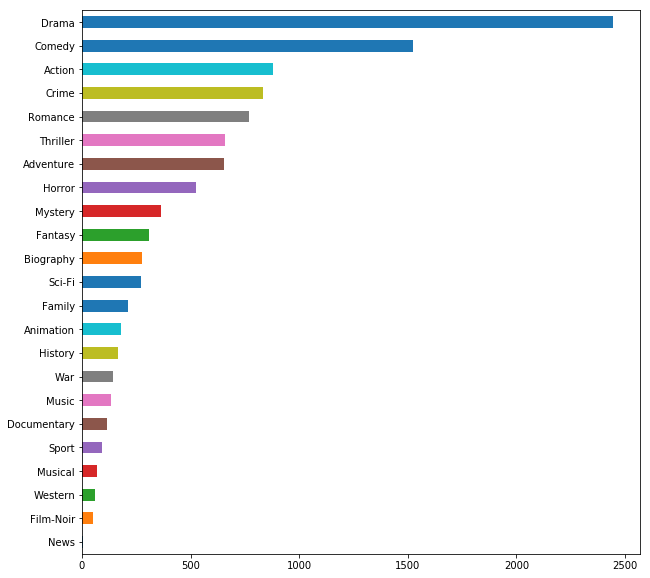

In [19]:
# TODO Change style of graphe 
# TODO add x-axis label
# Plotting genre distribution 
genres = [item for sublist in df_films_stats["genres"] for item in sublist]
ax = pd.Series(genres).groupby(genres).count().sort_values().plot.barh(figsize=(10,10))

### How is our dataset distributed through time?

Oldest movie in our dataset was released on: 1922
Newest movie in our dataset was released on: 2018


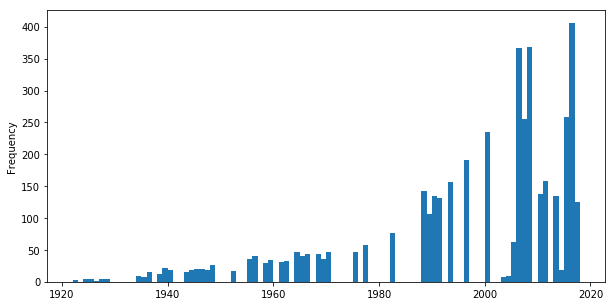

In [20]:
# TODO Change style of graphe 
print("Oldest movie in our dataset was released on: {:}".format(df_films_stats["year"].min()))
print("Newest movie in our dataset was released on: {:}".format(df_films_stats["year"].max()))
ax = df_films_stats["year"].plot.hist(bins=96, figsize=(10,5))

As we can see the data is not distributed evenly through time, a lot of years are missing and more recent films appear more. It will be then difficult to take time into account as a good metric to predict the rating given the uneven distribution

### How is the total film runtime distributed?

Shortest movie in our dataset is: 45.0 minutes long
Longest movie in our dataset is: 467.0 minutes long


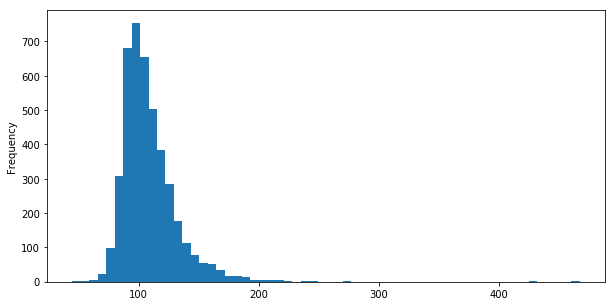

In [21]:
# TODO Change style of graphe 
print("Shortest movie in our dataset is: {:} minutes long".format(df_films_stats["runtimeMinutes"].min()))
print("Longest movie in our dataset is: {:} minutes long".format(df_films_stats["runtimeMinutes"].max()))

# TODO add x-axis label!
ax = df_films_stats["runtimeMinutes"].plot.hist(bins=60, figsize=(10,5))

Apart from some outliers, our data is well centered to the runtime value of 100 minutes.

### What about the ratings?

Worst rated movie in our dataset has: 1.7 rating
Best rated movie in our dataset has: 9.4 rating
Average rating in our dataset is 6.7


Text(0.5,0,'Average Rating')

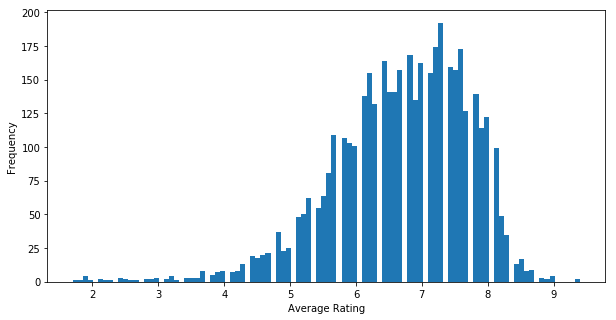

In [23]:
# TODO Change style of graphe 
print("Worst rated movie in our dataset has: {:.1f} rating".format(df_films_stats["averageRating"].min()))
print("Best rated movie in our dataset has: {:.1f} rating".format(df_films_stats["averageRating"].max()))
print("Average rating in our dataset is {:.1f}".format(df_films_stats["averageRating"].mean()))
ax = df_films_stats["averageRating"].plot.hist(bins=100, figsize=(10,5))
ax.set_xlabel("Average Rating")
# ax.savefig

In [24]:
df_films_stats.sort_values("averageRating", ascending=False).head(10)

,tconst,num_sentences,year,blocks,subtitle_mins,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
2977,tt0252487,1617,1975,675,24.450000,movie,The Chaos Class,Hababam Sinifi,0,1975,\N,87.0,"[Comedy, Drama]",9.4,32554
3781,tt5813916,1570,2016,1440,71.366667,movie,The Mountain II,Dag II,0,2016,\N,135.0,"[Drama, War]",9.4,98731
3938,tt5275892,6236,2016,1829,406.050000,movie,O.J.: Made in America,O.J.: Made in America,0,2016,\N,467.0,"[Biography, Crime, Documentary]",9.0,14176
1218,tt0084302,1045,1982,462,29.433333,movie,The Marathon Family,Maratonci trce pocasni krug,0,1982,\N,92.0,"[Comedy, Drama]",9.0,12553
1675,tt0468569,2050,2008,694,86.433333,movie,The Dark Knight,The Dark Knight,0,2008,\N,152.0,"[Action, Crime, Drama]",9.0,1986545
3151,tt0252488,1689,1975,1113,23.283333,movie,The Chaos Class Failed the Class,Hababam Sinifi Sinifta Kaldi,0,1976,\N,91.0,[Comedy],9.0,18838
1028,tt0060196,2071,1966,1434,282.416667,movie,"The Good, the Bad and the Ugly","Il buono, il brutto, il cattivo",0,1966,\N,161.0,[Western],8.9,598247
444,tt0108052,2917,1993,1133,126.366667,movie,Schindler's List,Schindler's List,0,1993,\N,195.0,"[Biography, Drama, History]",8.9,1042076
1172,tt1375666,1570,2010,1190,79.416667,movie,Inception,Inception,0,2010,\N,148.0,"[Action, Adventure, Sci-Fi]",8.8,1766484
1967,tt0214915,1537,1993,1269,95.950000,movie,Manichithrathazhu,Manichithrathazhu,0,1993,\N,169.0,"[Comedy, Horror, Musical]",8.8,5845


We can see already that an outlier in our distribution plots will be the film "OJ made in america" as its runtime is 467 minutes long. We'll see explore the different outliers in our plots later on.

## Simple statistics: searching for a correlation between average IMDb rating and text features. 

"Raw" features are extracted from the subtitles and the metadata : 
* the total number of words relative to the movie duration. 
* the total number of distinct words relative to the movie duration.
* the total number of sentences relative to the movie duration.
* the mean average length of the subtitles.
* the subtitles to movie duration ratio.
* the number of distinct words divided by the length of the movie, the total number of words and the mean average length of the sentences.

We define the following method to extract these features from our dataframe.

In [147]:
def word_statistics(df_films):
    # Explode the sentences t
    df_words = df_films.select('*', psf.explode('subtitles').alias('words'))
    df_words = df_words.select('*', psf.explode('words').alias('word'))

    df_word_counts = df_words.groupby("tconst", "num_sentences", "subtitle_mins")\
                             .agg(psf.count("word").alias("num_words"), 
                                  psf.countDistinct("word").alias("num_distinct_words"))\
                             .join(df_basics, ['tconst'], 'inner')\
                             .withColumn("words_per_min",
                                         psf.col("num_words") / psf.col("runtimeMinutes"))\
                             .withColumn("distinct_words_per_min",
                                         psf.col("num_distinct_words") / psf.col("runtimeMinutes"))\
                             .withColumn("sentences_per_min",
                                         psf.col("num_sentences") / psf.col("runtimeMinutes"))\
                             .withColumn("mean_length_sentences",
                                         psf.col("num_words") / psf.col("num_sentences"))\
                             .withColumn("distinct_index", 
                                         1000 * psf.col("num_distinct_words") /(psf.col("num_sentences")*
                                                                                psf.col("runtimeMinutes")*
                                                                                psf.col("num_words")))\
                             .withColumn("times_ratio",
                                         psf.when(psf.col("subtitle_mins").isNotNull(), 
                                                  psf.col("subtitle_mins") / psf.col("runtimeMinutes") * 100))
    
    df_word_counts = df_word_counts.select("tconst",
                                           "num_words",
                                           "num_distinct_words",
                                           "num_sentences",
                                           "subtitle_mins",
                                           "runtimeMinutes",
                                           "mean_length_sentences",
                                           "words_per_min",
                                           "distinct_words_per_min",
                                           "sentences_per_min",
                                           "distinct_index",
                                           "times_ratio")
    return df_word_counts

In [148]:
# load data  

# df_films = spark.read.parquet("parquets/films.parquet")

In [149]:
# Generating the df of statistics 
# df_stats = word_statistics(df_films)

In [150]:
# df_stats.printSchema()

In [151]:
# Saving the df of statistics 
# df_stats.write.mode("overwrite").parquet("parquets/stats.parquet")

### Plots 

For each feature we plot a scatter plot vs movies' average ratings to search for a dependency between each feature and a movie's average.

#### Conversion to pandas dataframe 

In [152]:
# Load from parquet 
df_words_stats = spark.read.parquet("parquets/stats.parquet")

In [180]:
# join with ratings to get average rating: 
df_words_ratings = df_words_stats.join(other=df_ratings, 
                                       on='tconst', 
                                       how='inner')
# join with basics to get title:
# df_words_ratings = df_words_ratings.join(other=df_basics.select('tconst',
#                                                                 'originalTitle', 
#                                                                 'titleType'), 
#                                          on='tconst', 
#                                          how='inner')

In [181]:
df_words_ratings_pd = df_words_ratings.toPandas()

In [182]:
df_words_ratings_pd.head()

,tconst,num_words,num_distinct_words,num_sentences,subtitle_mins,runtimeMinutes,mean_length_sentences,words_per_min,distinct_words_per_min,sentences_per_min,distinct_index,times_ratio,averageRating,numVotes
0,tt0013086,5515,1498,723,206.866667,242.0,7.627939,22.789256,6.190083,2.987603,0.001552,85.482094,7.9,6263
1,tt0013257,4110,1291,344,44.700000,91.0,11.947674,45.164835,14.186813,3.780220,0.010034,49.120879,7.7,9757
2,tt0013442,1324,586,169,32.650000,94.0,7.834320,14.085106,6.234043,1.797872,0.027861,34.734043,8.0,78620
3,tt0015064,145,113,15,23.450000,77.0,9.666667,1.883117,1.467532,0.194805,0.674728,30.454545,8.1,10730
4,tt0015163,487,299,75,NaN,59.0,6.493333,8.254237,5.067797,1.271186,0.138749,NaN,8.0,7894


In [183]:
df_words_ratings_pd['num_words'].describe()

count     4275.000000
mean      7651.918129
std       3556.178555
min         25.000000
25%       5324.500000
50%       7256.000000
75%       9513.000000
max      59152.000000
Name: num_words, dtype: float64

We check aswell if we have many null values that might affect our statistics.

In [184]:
df_words_ratings_pd.isna().sum()

tconst                     0
num_words                  0
num_distinct_words         0
num_sentences              0
subtitle_mins             62
runtimeMinutes             0
mean_length_sentences      0
words_per_min              0
distinct_words_per_min     0
sentences_per_min          0
distinct_index             0
times_ratio               62
averageRating              0
numVotes                   0
dtype: int64

The number is negligible and is due to the conversion of subtitle minutes of some XML files that had a slightly different datetime format. To avoid surprises we decide to drop films with null values.

In [185]:
df_words_ratings_pd = df_words_ratings_pd.dropna()

Using the resulting dataframe we first look at it statistics for each entry.
Then we plot each column vs the average rating to see if we find some kind of linear dependency.
We also plot the histograms of each metric for films we consider "good" and films we consider "bad" to see if we have different distributions for such metrics. We take a balanced set aswell, we consider good films the ones that have more than 8 as imdb rating and bad those who have less than 5.2

In [192]:
bad_movies = df_words_ratings_pd[df_words_ratings_pd.averageRating <= 5.2]
good_movies = df_words_ratings_pd[df_words_ratings_pd.averageRating >= 8]

In [193]:
(bad_movies["tconst"].count(), good_movies["tconst"].count())

(353, 355)

We see it is a fairly balanced set.

We look at the statistical description of our statistics.

In [187]:
# print("Means:")
# print(df_words_ratings_pd.mean(), "\n")
# print("Medians:")
# print(df_words_ratings_pd.median(), "\n")
# print("Std deviations")
# print(df_words_ratings_pd.std())
df_words_ratings_pd.describe()

,num_words,num_distinct_words,num_sentences,subtitle_mins,runtimeMinutes,mean_length_sentences,words_per_min,distinct_words_per_min,sentences_per_min,distinct_index,times_ratio,averageRating,numVotes
count,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4.213000e+03
mean,7712.322336,1518.511749,1471.671018,45.923166,108.876810,5.302917,71.268341,14.181921,13.672092,0.003938,40.146395,6.681484,5.395586e+04
std,3514.555867,458.405460,625.768173,29.366042,22.844862,1.224145,29.476201,4.200260,5.557989,0.059104,18.584565,1.027939,1.089528e+05
min,31.000000,17.000000,3.000000,0.150000,60.000000,1.033333,0.313131,0.171717,0.033708,0.000033,0.227273,1.700000,5.001000e+03
25%,5389.000000,1227.000000,1055.000000,29.483333,94.000000,4.639791,51.443709,11.448980,10.021277,0.000918,31.344697,6.100000,8.155000e+03
50%,7280.000000,1501.000000,1407.000000,39.666667,104.000000,5.102339,68.149533,13.955556,13.114286,0.001398,38.015873,6.800000,1.660100e+04
75%,9531.000000,1802.000000,1811.000000,54.466667,118.000000,5.658429,88.277311,16.820896,16.886792,0.002207,45.739130,7.400000,4.992200e+04
max,59152.000000,5751.000000,7083.000000,504.083333,467.000000,17.637228,276.081633,33.767123,72.275510,3.537245,438.439716,9.400000,1.986545e+06


### Correlations 

We compute the correlation between our statistics and the average rating of a film and we look at the different scatter plots. On the X-axis we put our statistics and on the Y-axis the average rating. We want to use the features that reveal the most information about the rating of a movie for a regression.

We also plot the distribution of the found features for subsets of "good movies", as stated in the section just before. We want to see if their distributions are similar, if they reveal any additional information.

In [188]:
df_words_ratings_pd.corr()["averageRating"].sort_values(ascending=False)

averageRating             1.000000
runtimeMinutes            0.306696
subtitle_mins             0.269166
numVotes                  0.226106
times_ratio               0.210585
mean_length_sentences     0.201058
num_words                 0.145732
num_distinct_words        0.124272
num_sentences             0.047552
words_per_min             0.008016
distinct_index            0.004574
distinct_words_per_min   -0.074143
sentences_per_min        -0.104072
Name: averageRating, dtype: float64

#### Plots for words 

We check whether raw features from the subtitles of the movies correlate with the average IMDb rating.  
It starts with some features about the words used in the subtitles. 

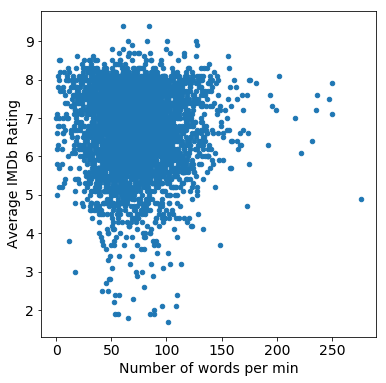

In [189]:
ax = df_words_ratings_pd.plot.scatter("words_per_min", 
                                      "averageRating",
                                      figsize=(6,6),
                                      fontsize=14);
plt.xlabel('Number of words per min',fontsize=14);
plt.ylabel('Average IMDb Rating',fontsize=14);

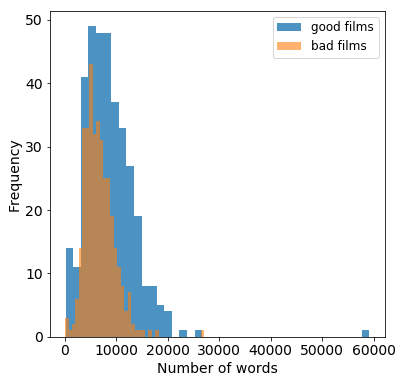

In [190]:
plt.figure(figsize=(6,6))
good_movies["num_words"].plot.hist(bins=40,
                                   fontsize=14, 
                                   alpha=0.8,
                                   label="good films")
bad_movies["num_words"].plot.hist(bins=40,
                                  fontsize=14, 
                                  alpha=0.6, 
                                  label="bad films")
plt.xlabel('Number of words', fontsize=14);
plt.ylabel('Frequency',fontsize=14); 
plt.legend(loc="upper right", fontsize=12)
plt.show()

As we can see, there does not seem to be a major relation between the number of words in a movie and its rating, both good and bad films distributions are pretty similar though more words in a film seems to help it have a better rating.
##### Outlier
We can see there is a strange outlier in our scatter plot, we stated the film OJ made in america seemed odd as its runtime was more than 6 hours

In [191]:
df_words_ratings_pd.iloc[df_words_ratings_pd["num_words"].idxmax()]["originalTitle"]

KeyError: 'originalTitle'

The outlier is indeed OJ made in America. We need to consider the runtime of the movie to use the number of words as a metric as it is natural for a longer film to have more words. We do this next

In [ ]:
ax = df_words_ratings_pd.plot.scatter("words_per_min", 
                                      "averageRating",
                                      figsize=(6,6),
                                      fontsize=14);
plt.xlabel('Number of words per min', fontsize=14);
plt.ylabel('Average IMDb Rating', fontsize=14);

In [ ]:
plt.figure(figsize=(6,6))
good_movies["words_per_min"].plot.hist(bins=40,
                                       fontsize=14, 
                                       alpha=0.8,
                                       label="good films")
bad_movies["words_per_min"].plot.hist(bins=40,
                                      fontsize=14, 
                                      alpha=0.6, 
                                      label="bad films")
plt.xlabel('Number of words per min',fontsize=14);
plt.ylabel('Frequency', fontsize=14); 
plt.legend(loc="upper right", fontsize=12)
plt.show()

As we can see there is no outlier like in our last plot as we divided by the total runtime of the movie. Though this statistic still does not reveal much about rating. Both good and bad films distributions are still very similar

##### Comments :

Looking at the plots reveals that there is not clear distinction in the average IMDb rating based on how many subtitles are employed in a movie.

* The first plot shows that most of the film use 5'000 to 15'000 words but that does not have a significant impact on the rating.
* The idea behind a the ratio $ \frac{x}{\text{Length of Movie}}$ where $x$ here is the number of words used in the movie, is simply to take into accound that movie that is longer could have in proportion the same amount of words employed. Indeed, a longer movie is not necessarly more verbose, it could only have more words used in it because it is longer. 
* The second plot does not provide much more information than the first and actually shows data more evenly distributed. 


#### Plots for distinct words : 

we iterate the previous analysis but this time looking at the distinct words. What is expected is that movies that use a larger vocabulary could have been written more caustiously, leading to better scenario and hence a better movie. 

In [ ]:
ax = df_words_ratings_pd.plot.scatter("distinct_words_per_min", 
                                      "averageRating",
                                      figsize=(6,6),
                                      fontsize=14);
plt.xlabel('Number of distinct words per min', fontsize=14);
plt.ylabel('Average IMDb Rating', fontsize=14);

In [ ]:
#TODO : what's up with this 
df_words_ratings_pd.iloc[df_words_ratings_pd["num_distinct_words"].idxmax()]["originalTitle"]

In [ ]:
good_movies["num_distinct_words"].plot.hist(bins=40,
                                            alpha=0.8,
                                            label="good films");
bad_movies["num_distinct_words"].plot.hist(bins=40,
                                           figsize=(6,6), 
                                           fontsize=14,alpha=0.6,
                                           label="bad films");

plt.xlabel('Number of distinct words', fontsize=14);
plt.ylabel('Frequency', fontsize=14);
plt.legend(loc="upper right", fontsize=12)
plt.show()

Again, no general trend can be seen. To bring all movies on equal footing regarding the number of distinct words used in their subtitles, the number of distinct words is divided by : 
* the length of the movie
* the number of words used 
* the number of sentences 
and multiplied by 1000 to have larger numbers. 
The intuition is that any of these three parameters could influence the distinct number of words used : 
* longer movies provide more chances to use different words
* the more words used, the more diverse they can be
* more sentences provide more occasions to employ a larger vocabulary

In [ ]:
ax = df_words_ratings_pd.plot.scatter("distinct_index",
                                      "averageRating",
                                      figsize=(8,6), 
                                      fontsize=14);
plt.xlabel('Distinct Index', fontsize=14)
plt.ylabel('Average IMDb Rating', fontsize=14)

In [ ]:
df_words_ratings_pd['distinct_index'].describe()

By looking at the plote `distinct_index` vs `averageRating` and statistic description, we see that most of the movies are agglutinated to a single value as shown by the mean and the quartiles. 

##### Comments :

Again no clear trend can be seen. "Good" or "bad" movies are apparently are unfortunately undistinguishable from the point of view of distinct.
Some "outliers" showed up as we can see in the last plot. 
The only info we can retieve from this that some extremely verbose movie was a success but that does not mean that it sufficient to be a good movie. 

#### Plots for the number of  sentences and the mean length of sentences

We now instead of looking at the number of words, we look at the number of sentences, to see if this metric reveals something, though by what we found earlier with words, the distribution should be fairly similar.

In [ ]:
ax = df_words_ratings_pd.plot.scatter("sentences_per_min", "averageRating",figsize=(6,6),fontsize=14);
plt.xlabel('Number of sentences per min', fontsize=14);
plt.ylabel('Average IMDb Rating', fontsize=14);

From the plot above, it appears that again no clear trend can be established based on this statistics. 
Nevertherless, it seems that a larger number of sentences for the raw number of sentences and normalized with respect to movie length, correlates positevely with a higher IMDb rating. 
To have a higher IMDb rating it is not necessary to have longer sentences, as most of data is packed between a 1'000 and 3'000 sentences in the subtitles.  
But, it can be observed that a positive correlation appears for the movies with the longest sentences: looking a at the data on the right edge of the blobe shows that as the number of sentences increase, the average IMDb rating increases, as if passed a certain number of sentences garanties a certain IMDb average rating. 
Without doubt it is not the effect of longer sentences that is observed here, but longer sentences are more complicated to be written. Thus it can give an idea on how well the scripts of this movies where written and that could correlate positively with higher IMDb.

In [ ]:
# TODO do somtehing to visualize both 
good_movies["sentences_per_min"].plot.hist(bins=40, 
                                           alpha=0.8,
                                           label="good films");
bad_movies["sentences_per_min"].plot.hist(bins=40,
                                          figsize=(6,6),
                                          fontsize=14,
                                          alpha=0.6,
                                          label="bad films");
plt.xlabel('Sentences per min', fontsize=14);
plt.ylabel('Frequency', fontsize=14);
plt.legend(loc="upper right", fontsize=12)
plt.show()

This last plot on the number of sentences shows that this features is not polarized between good or bad movies : "good" movies do not necessarly have long or short sentences and vice-versa for "bad" movies. 

We continue the analysis at a different scale looking at the number of sentences in the movies and  the mean length of the sentences.  
We define such quantity as : $\bar{L} = \frac{1}{N}\sum_{s} l_{s}$ where $\bar{L}$ is the average length of sentences, $l_s$ is the length of the sentence indexed by $s$ and $N$ the total number of sentences in the subtitle of the movie. 
$l_s$ is simply the number of words in a sentence.

In [ ]:
ax = df_words_ratings_pd.plot.scatter("mean_length_sentences", "averageRating",figsize=(6,6),fontsize=14);
plt.xlabel('Mean length of sentences ', fontsize=14);
plt.ylabel('Average IMDb rating', fontsize=14);

In [ ]:
plt.figure(figsize=(6,6))
good_movies["mean_length_sentences"].plot.hist(bins=40,
                                               fontsize=14, 
                                               alpha=0.8,
                                               label="good films")
bad_movies["mean_length_sentences"].plot.hist(bins=40,
                                              fontsize=14, 
                                              alpha=0.6,
                                              label="bad films")
plt.xlabel('Mean length of sentences',fontsize=14);
plt.ylabel('Frequency',fontsize=14); 
plt.legend(loc="upper right", fontsize=12)
plt.show()

No plot show some clear difference between the two classes considered: "good" and "bad" movies can not be distinguished by the mean length of sentences.
An explanation for this is found when considering the purpose the main use of subtitles in movies : dialogue.
Dialogues tends to employ short sentences and in general, many people prefer short sentences as they are more easily understood. So the idea of longer sentences implying more "written". 
Nevertheless by looking at the plots of the total number of words versus the avarge IMDb rating it appear that writting longer sentences correlates positevely with the higher IMDb ratings (at the right edge of the blob made by the data). 
So what could be said is that, it is not a necessary condition but it seems that movies with the longest sentences on average have the better IMDb ratings in the end. 

#### Plots for durations 

We look at the subtitle minutes in a film and also the subtitle minutes/runtime minues ratio, meaning the amount of time spoken in a film relative to the total runtime

In [ ]:
ax = df_words_ratings_pd.plot.scatter("subtitle_mins", "averageRating",figsize=(6,6),fontsize=14);
plt.xlabel('Subtitle minutes', fontsize=14);
plt.ylabel('Average IMDb rating', fontsize=14);

In [ ]:
ax = df_words_ratings_pd.plot.scatter( "times_ratio", "averageRating",figsize=(6,6),fontsize=14);
plt.xlabel('$\\tau_{subs}/ \\tau_{movies} [\\%]$', fontsize=14);
plt.ylabel('Average IMDb rating', fontsize=14);

#### Outlier?

In [ ]:
df_words_ratings_pd.iloc[df_words_ratings_pd["times_ratio"].idxmax()]["originalTitle"]

### Word analysis

We don't see any promising relations between the average rating of a film and the found statistics hence we decide to compute a final one representing the average word length in a film. We filter out stopwords to come up with the average length of words to extract a metric which helps us represent "complexity" of the movie, as longer words tend to be more complex words. We know this is not strictly true as we might find words in subtitles such as "hahahaha" but we compute it nontheless to see if we find some insightfull information.

In [ ]:
df_all = spark.read.parquet("parquets/words/allwords.parquet/")
df_film_words = spark.read.parquet("parquets/words/filmwords.parquet/")
df_all.sort("count", ascending=False).show()
df_film_words.sort("count", ascending=False).show()

In [ ]:
nlp = spacy.load('en')
spacy_stopwords = set(spacy.lang.en.stop_words.STOP_WORDS)
df_film_words_filtered = df_film_words.filter(~psf.lower(df_film_words.word).isin(spacy_stopwords)).sort("count", ascending=False)
df_all_filtered =df_all.filter(~psf.lower(df_all.word).isin(spacy_stopwords)).sort("count", ascending=False)

Here we calculate the average word length of each word considering only non-stop words

In [ ]:
df_aux_word = df_film_words_filtered.selectExpr("tconst", "length(word) * count as product", "count")\
                                    .groupBy("tconst")
df_word_length = df_aux_word.agg({"count": "sum", 
                                 "product": "sum"})
df_word_length = df_word_length.withColumn("av_word_length", 
                                           df_word_length["sum(product)"] / df_word_length["sum(count)"])\
                                .select("tconst", "av_word_length")
df_word_length.show()

In [ ]:
df_word_length_pd = df_word_length.join(df_ratings, ["tconst"]).toPandas()

In [ ]:
ax = df_word_length_pd.plot.scatter("av_word_length", 
                                    "averageRating", 
                                    figsize=(6,6), 
                                    fontsize=14)
df_word_length_pd.iloc[df_word_length_pd["av_word_length"].idxmax()]
df_word_length_pd["av_word_length"].corr(df_word_length_pd["averageRating"])
plt.xlabel('Average Word length', fontsize=14);
plt.ylabel('Average IMDb rating', fontsize=14);

#### Outlier?
There is a weird outlier in our distribution, we look into the subtitles to see why such anomaly is present

We plot again the distribution without the outlier present to see if it might reveal a relation between average film rating and average word length.

In [ ]:
ax = df_word_length_pd.plot.scatter("av_word_length", 
                                    "averageRating", 
                                    figsize=(6,6),
                                    fontsize=14)
df_word_length_pd.iloc[df_word_length_pd["av_word_length"].idxmax()]
plt.xlim(3,7)
plt.xlabel('Average Word length', fontsize=14);
plt.ylabel('Average IMDb rating', fontsize=14);

As with the other stats before, this does not reveal a lot of information regarding the film's rating. We stop looking at this metric to predict the film rating.

# Trying to predict the IMDb average rating:

Even though we don't see a big dependency between the statistics found and the movie rating, we'll try to do a regression model based on them to see its accuracy, how well it predicts the rating. We don't expect a good result from the exploration performed before. For the feature columns we take only those which had the bigger correlation and seemed to reveal more information about the rating.

In [ ]:
feature_columns = ["runtimeMinutes", 
                   "subtitle_mins",
                   "numVotes",
                   "times_ratio",
                   "mean_length_sentences", 
                   "num_words",           
                    "num_distinct_words"]
X = df_words_ratings_pd[feature_columns]
normal_X = (X- X.mean()) /X.std()
normal_X = normal_X.fillna(0)
y = df_words_ratings_pd["averageRating"]

In [ ]:
regression = LinearRegression()
predicted = cross_val_predict(regression, normal_X, y, cv=5)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

As we can see and expected... no real causation, our model predicts that all films have a better rating than 6. This means that among the stats we have there is no information that might reveal when a film is bad.

These plots show us little relation between the found metrics and the actual film rating, the only thing we could state is that films with more text tend to be better rated. We now look at the different genres.


## Genre Exploration

Here we find the average rating for the 10 most represented genres.

In [ ]:
df_genres = df_films.drop("subtitles").join(df_basics.select("tconst", 
                                                             "genres", 
                                                             "primaryTitle", 
                                                             "runtimeMinutes"), 
                                            ["tconst"])
df_genres = df_genres.join(df_ratings, ["tconst"])

In [ ]:
df_genres_avRating = df_genres.select('*', 
                                      psf.explode('genres').alias('genre'))\
                              .groupBy("genre").agg({"averageRating": "mean", 
                                                     "*": "count"})
df_genres_rating_pd = df_genres_avRating.sort("count(1)", ascending=False).limit(10).toPandas()

We can see that there are no very big differences between genres apparently, though we can see that a Drama movie is more likely to have a good rating than a horror movie. From these statistics we could assume that the genre has somehow an influence in the film's average rating.


In [ ]:
df_genres_rating_pd.sort_values("avg(averageRating)", ascending=False).plot.bar(y="avg(averageRating)", x="genre")
plt.ylim(5.5, 7.5)
plt.show()

## Time Exploration

We categorize our films into 3 time periods

In [ ]:
def add_time_period(year):
    if year < 1910 or year > 2018:
        return "NaN"
    elif year < 1960:
        return "1910-1959"
    elif year < 2000:
        return "1960-1999"
    else:
        return "2000s"
udf_period = psf.udf(add_time_period, StringType())

In [ ]:
df_words_ratings_periods = df_words_ratings.join(df_films.select("year", "tconst"), ["tconst"])\
                                           .withColumn("period", udf_period("year"))
df_words_ratings_periods.groupBy("period").count().show()

Not very balanced

In [ ]:
df_words_ratings_periods.groupBy("period").agg({"averageRating": "mean"}).show()

Are films getting worse? Can't be sure as the amount of films is not big enough but from our data it would seem so

Check distributions for each time period

In [ ]:
df_periods_stats = df_words_ratings_periods.join(df_genres.select("tconst", 
                                                                  psf.explode('genres').alias('genre')), 
                                                 ["tconst"])\
                                           .groupBy("period", "genre").agg({"averageRating": "mean", 
                                                                            "*": "count"})
df_periods_stats_pd = df_periods_stats.toPandas()

In [ ]:
df_genres = df_films.drop("subtitles").join(df_basics.select("tconst", 
                                                             "genres", 
                                                             "primaryTitle", 
                                                             "runtimeMinutes"), 
                                            ["tconst"])
df_genres= df_genres.join(df_ratings, ["tconst"])

#### Subtitles to String and time period separation functions

In [ ]:
df_periods_stats_pd[df_periods_stats_pd["count(1)"] > 100].sort_values("avg(averageRating)", ascending=False)

## Text analysis

As we can see, maybe using genre and the time period as parameter for a regression might result in better predictions, but it is clearly not good enough. We need to go deeper, look at the content of the actual text. We'll implement a sentiment analysis on some of the best films and some of the worst films and see if we can find some kind of dependency.

In [ ]:
df_films_strings = spark.read.parquet("parquets/filmtext.parquet/")

### SENTIMENT ANALYSIS. 

For the sentiment analysis we take as metrics the average positive and negative sentiment of the film which we define as the total positive (negative) score of each sentence, divided by the total number of sentences. As these are fairly heavy computations we will look at only the best and worst to start. (the 50 best and the 50 worst)

In [ ]:
df_strings = df_films_strings.join(df_ratings, ["tconst"]).toPandas()

In [ ]:
analyzer = SentimentIntensityAnalyzer()
def av_sentiments_film(text):
    document = nlp(text)
    positive_sent = 0
    negative_sent = 0
    sents = document.sents
    count = 0
    for sent in sents:
        positive_sent += analyzer.polarity_scores(sent.text)['pos']
        negative_sent += analyzer.polarity_scores(sent.text)['neg']
        count += 1
    return (positive_sent/count, negative_sent/count)


In [ ]:
#TODO CHoose number of subtitles,
df_strings_best = df_strings.sort_values("averageRating", ascending=False).head(100)
df_strings_worst = df_strings.sort_values("averageRating", ascending=True).head(100)
df_strings_best["av_sentiment"] = df_strings_best["text"].apply(av_sentiments_film)
df_strings_worst["av_sentiment"] = df_strings_worst["text"].apply(av_sentiments_film)


In [ ]:
df_strings_best[['positive', 'negative']] = df_strings_best['av_sentiment'].apply(pd.Series)
df_strings_worst[['positive', 'negative']] = df_strings_worst['av_sentiment'].apply(pd.Series)

In [ ]:
print("The median positive sentiment of best and worst films is")
print(df_strings_best["positive"].median())
print(df_strings_worst["positive"].median())

In [ ]:
ax = df_strings_best.plot.scatter("positive", "averageRating")

In [ ]:
ax = df_strings_worst.plot.scatter("positive", "averageRating")

In [ ]:
df_strings_best["positive"].plot.hist(alpha=0.8, label="best films")
df_strings_worst["positive"].plot.hist(alpha=0.6, label="worst films",figsize=(6,6),fontsize=14);
plt.xlabel('Positive sentiment of movie ', fontsize=14);
plt.ylabel('Frequency', fontsize=14);
plt.legend(loc='upper right', fontsize=12)
plt.show()

In [ ]:
ax = df_strings_best.plot.scatter("negative", "averageRating")

In [ ]:
ax = df_strings_worst.plot.scatter("negative", "averageRating")

In [ ]:
df_strings_best["negative"].plot.hist(alpha=0.8, label="best films")
df_strings_worst["negative"].plot.hist(alpha=0.6, label="worst films",figsize=(6,6),fontsize=14);
plt.xlabel('Negative sentiment of movie ', fontsize=14);
plt.ylabel('Frequency', fontsize=14);
plt.legend(loc='upper right', fontsize=12)
plt.show()

In [ ]:
print("Median negative sentiment of best and worst films is")
print(df_strings_best["negative"].median())
print(df_strings_worst["negative"].median())

This plots dont seem to give us any major relation between rating and average positive or negative sentiment of a film. We dont consider a larger data set as we can see no major relation. Only things we can conclude is that films in general have more of a positive sentiment than a negative sentiment, that good films tend to be a tiny bit less positive and less negative.